# Example Spatial Target Cells Visualization

This notebook contains plots of example cells from the spatial target analysis. 

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.spatial.occupancy import (compute_bin_counts_assgn, compute_bin_edges, 
                                          compute_bin_assignment, normalize_bin_counts)
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_occupancy, compute_bin_counts_pos
from spiketools.spatial.utils import compute_nbins, compute_pos_ranges, convert_2dindices
from spiketools.spatial.target import compute_target_bins
from spiketools.utils.data import compute_range, smooth_data
from spiketools.utils.extract import (get_range, get_value_by_time, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_times)
from spiketools.utils.epoch import epoch_data_by_range 

from spiketools.plts.spatial import plot_heatmap, create_heat_title, plot_positions
from spiketools.plts.utils import make_axes, save_figure

In [3]:
import sys
sys.path.append('../code')

from utils import *
from plts import *

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/nwb'

In [6]:
# Define session information
session = {
    'experiment' : 'THO',
    'subject' : 'wv002',
    'session' : 1
}

In [7]:
# Set which example unit to extract
uind = 4

In [8]:
# Define binning for chests (spatial target)
chest_bins = [5, 8]
bins = [7, 10]
n_bins = compute_nbins(chest_bins)

In [9]:
# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

## Load data

In [10]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)

In [11]:
# Load example NWB file
nwbfile = load_nwbfile(session, data_folder)

### Get trial data

In [12]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [13]:
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]
ch_openings_all = np.array(chest_openings).reshape(-1,1)

### Get spike data

In [14]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 87
Number to keep:  62


In [15]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

### Get position data

In [16]:
# # Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:],
              nwbfile.acquisition['boundaries']['z_range'].data[:]]

# area_range = [np.array([349.8549, 419.8549]), np.array([300,410])]

In [17]:
# Get position & speed information
positions = nwbfile.acquisition['position']['player_position'].data[:].T
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [18]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.1)

## Chest position

In [19]:
# Define the area range for chest appearance 
area_range_chest = [[360, 410], [320, 400]]

# Get chest positions
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

# Compute edges for chest binning
x_edges, y_edges = compute_bin_edges(positions, chest_bins, area_range=area_range_chest)

# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_bin_assignment(chest_pos, x_edges, y_edges)

# Compute the 1d equivalent of the 2d indices
chbins = convert_2dindices(ch_xbin, ch_ybin, chest_bins)

In [20]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
chest_trial_number = np.array(list(range(len(chest_trials)))).reshape(n_trials,4)

In [21]:
# Compute chest occupancy
chest_occupancy = compute_bin_counts_assgn(chest_bins, ch_xbin, ch_ybin)

# Compute the segment firing rate per chest segment, per trial
target_frs = compute_segment_frs(spikes, seg_times)

# Compute the average firing across spatial target bins
target_bins = compute_target_bins(target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)
reshaped_target_bins = reshape_bins(target_bins, bins)

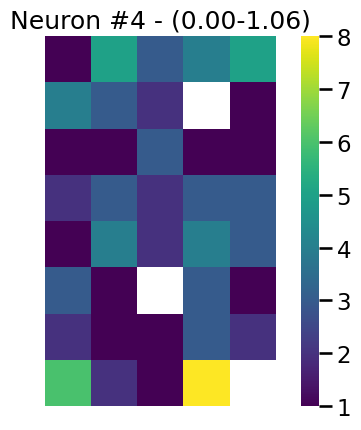

In [22]:
# Check the firing rate per spatial target for an example neuron
plot_heatmap(chest_occupancy, ignore_zero=True, title=create_heat_title('Neuron #{}'.format(uind), 
                                                                    target_bins), cbar=True)

## One example target cell

In [23]:
# Smooth the data and reshape it into to a different binning for visualization
smooth_target = smooth_data(target_bins, 1.1)
reshaped_target_bins = reshape_bins(smooth_target, bins)

In [24]:
# Get the navigation path and spikes associated with chests in each bin 
chests_per_bin, empty_bins = [], []
chest_x_all, chest_y_all = [], []
tpos_per_bin, tspikes_pos_per_bin = [], []

for ind in range(n_bins):
    
    bin_pos = list(set(np.where(chbins==ind)[0]))
    chests_per_bin.append(bin_pos)
    
    if bin_pos == []:
        empty_bins.append(ind)
        tpos_per_bin.append([])
        tspikes_pos_per_bin.append([])
        chest_x_all.append([])
        chest_y_all.append([])
    else: 
        chest_x = [chest_pos[0][i] for i in chests_per_bin[ind]]
        chest_y =[chest_pos[1][i] for i in chests_per_bin[ind]]
        chest_x_all.append(chest_x)
        chest_y_all.append(chest_y)
        tpos_all, tspikes_pos = get_pos_per_bin(chests_per_bin[ind], chest_trial_number, ptimes, 
                                                positions, spikes, nav_starts, ch_openings_all)
        tpos_per_bin.append(tpos_all)
        tspikes_pos_per_bin.append(tspikes_pos)

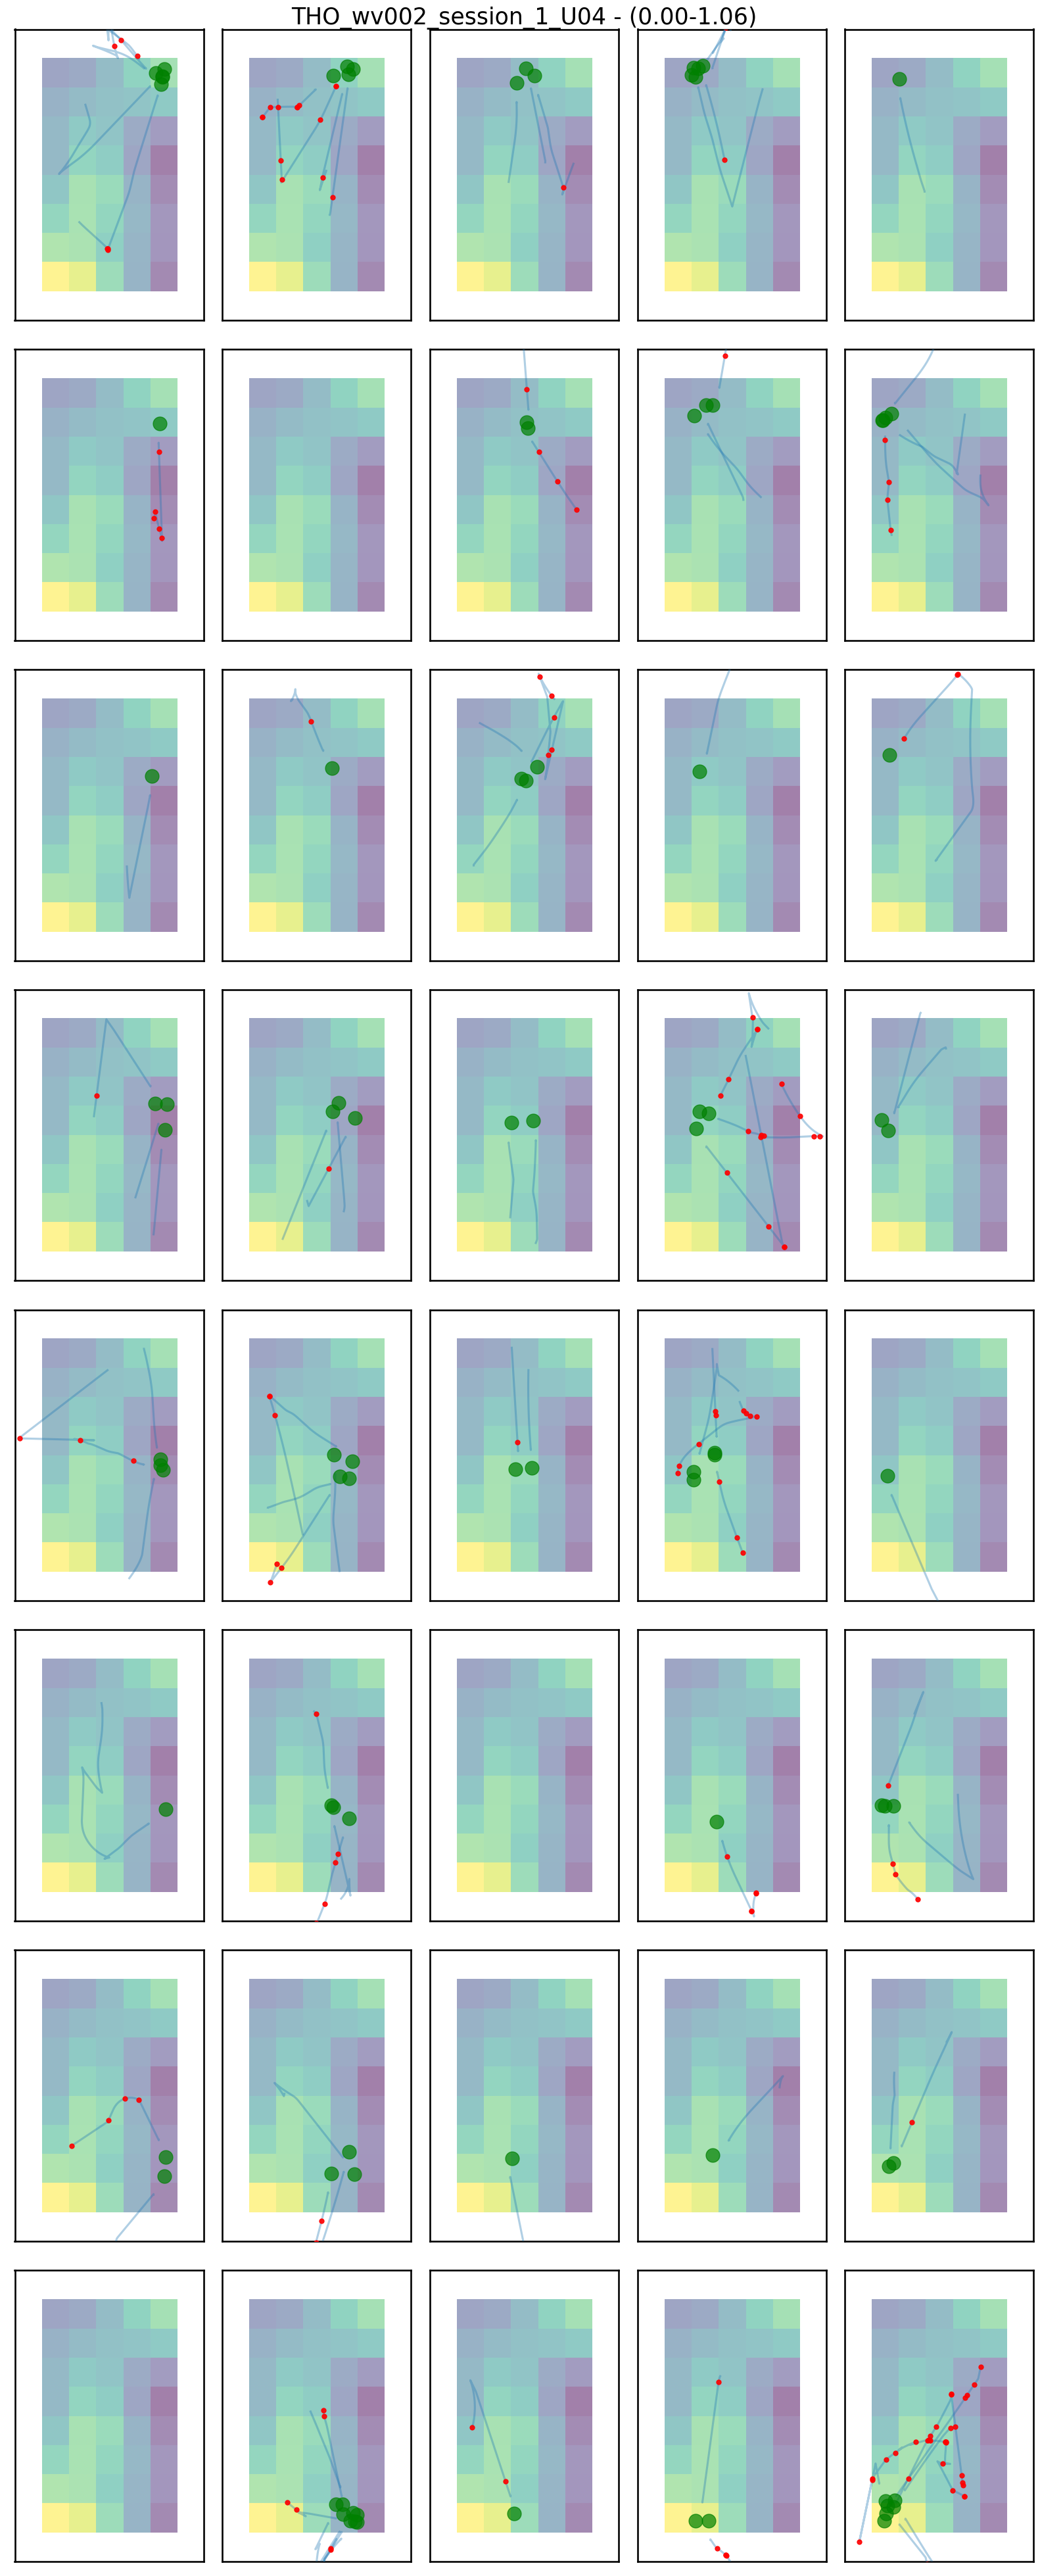

In [25]:
# Plot the navigation path and spikes associated with chests in each bin 
name = nwbfile.session_id + '_U' + str(uind).zfill(2)
plot_example_target(n_bins, target_bins, reshaped_target_bins, chests_per_bin, tpos_per_bin, 
                    tspikes_pos_per_bin, chest_x_all, chest_y_all, area_range, name)

## All significant target cells

In [26]:
# Load & merge the results sheets of THF & THO
df_THO = pd.read_csv("/Users/clairehan/Desktop/research/new_results/THO_combined_all_results.csv")
df_THF = pd.read_csv("/Users/clairehan/Desktop/research/new_results/THF_combined_all_results.csv")
df = df_THF.append(df_THO)

In [27]:
# Create a dataframe for significant spatial target cells
df_target = df[df.is_target_cell]
df_target

,Unnamed: 0,uid,session_id,subject_id,wvID,keep,n_spikes,firing_rate,cluster,channel,...,serial_anova_surr_z_score,keep_th,region,is_chest_cell,is_full_cell,is_empty_cell,is_target_cell,is_sp_cell,is_ID_cell,is_baseline_cell
6,6,8,THF_wv001_session_0,wv001,9,True,1079,0.866408,2248,A15,...,2.490977,False,AH,False,False,True,True,True,False,False
10,10,12,THF_wv001_session_0,wv001,13,True,702,0.555959,2130,A17,...,-0.453309,False,PH,False,False,False,True,False,False,False
11,11,13,THF_wv001_session_0,wv001,14,True,635,0.502897,2195,A17,...,1.243191,False,PH,False,False,False,True,False,False,False
15,15,18,THF_wv001_session_0,wv001,19,True,526,0.417657,2306,A17,...,0.392490,False,PH,False,False,False,True,False,False,False
37,37,53,THF_wv001_session_0,wv001,54,True,748,0.598272,2951,A29,...,0.818044,False,AMY,True,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,533,20,THO_wv004_session_3,wv004,793,True,1942,1.098724,6917,A20,...,0.208881,False,PH,False,False,False,True,False,False,False
551,551,46,THO_wv004_session_3,wv004,819,True,1957,1.108770,5232,A2,...,-0.884912,False,AMY,False,False,False,True,False,False,False
564,564,63,THO_wv004_session_3,wv004,836,True,838,0.476736,6186,A5,...,0.487081,False,AMY,False,False,False,True,False,False,False
587,587,12,THO_wv005_session_0,wv005,866,True,710,0.369782,3916,A3,...,-0.336482,False,AMY,False,False,False,True,False,False,False


In [78]:
# Plot the visualization for all significant target cells
for nwbfile in nwbfiles:
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    name = nwbfile.session_id
    
    # Get indices of significant target cell from each session
    inds = np.where(df_target.session_id == name)[0]
    inds_uid = df_target.uid.iloc[inds].values
    
    # Get trial information 
    n_trials = len(nwbfile.trials)
    nav_starts = nwbfile.trials.navigation_start[:]
    nav_stops = nwbfile.trials.navigation_stop[:]
    chest_openings = nwbfile.trials['chest_opening_time'][:]
    ch_openings_all = np.array(chest_openings).reshape(-1,1)

    # Get area ranges
    area_range= [nwbfile.acquisition['boundaries']['x_range'].data[:], 
                 nwbfile.acquisition['boundaries']['z_range'].data[:]]
    
    # Get position & speed information
    positions = nwbfile.acquisition['position']['player_position'].data[:].T
    ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
    stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
    speed = nwbfile.processing['position_measures']['speed'].data[:]

    # Get position data for navigation segments
    ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
    stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

    # Recombine position data across selected navigation trials
    ptimes = np.hstack(ptimes_trials)
    positions = np.hstack(positions_trials)
    stimes = np.hstack(stimes_trials)
    speed = np.hstack(speed_trials)

    # Get chest positions
    chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
    chest_trials = nwbfile.trials.chest_trials[:]
    chest_trial_number = np.array(list(range(len(chest_trials)))).reshape(n_trials,4)
    
    # Compute edges for chest binning
    x_edges, y_edges = compute_bin_edges(positions, chest_bins, area_range=area_range_chest)

    # Assign each chest to a bin
    chest_pos = np.array([chest_xs, chest_ys])
    ch_xbin, ch_ybin = compute_bin_assignment(chest_pos, x_edges, y_edges)
    
    # Compute the 1d equivalent of the 2d indices
    chbins = convert_2dindices(ch_xbin, ch_ybin, chest_bins)

    # Compute chest occupancy
    chest_occupancy = compute_bin_counts_assgn(chest_bins, ch_xbin, ch_ybin)
    
    # Define the segment times of interest
    seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
    
    for ind in inds_uid: 
        name_ind = nwbfile.session_id + '_U' + str(ind).zfill(2)
        
        # Get spike data for each significant unit
        spikes = nwbfile.units.get_unit_spike_times(ind)
        spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.1)
        
        # Compute firing rate per spatial target bin
        target_frs = compute_segment_frs(spikes, seg_times)
        target_bins = compute_target_bins(target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)
        smoothed_target_bins = smooth_data(target_bins, 1.1)
        reshaped_target_bins = reshape_bins(smoothed_target_bins, bins)
        
        # Get the spikes, subject path, chest positions for each bin 
        chests_per_bin, empty_bins = [], []
        chest_x_all, chest_y_all = [], []
        tpos_per_bin, tspikes_pos_per_bin = [], []

        for ind in range(n_bins):

            bin_pos = list(set(np.where(chbins==ind)[0]))
            chests_per_bin.append(bin_pos)

            if bin_pos == []:
                empty_bins.append(ind)
                tpos_per_bin.append([])
                tspikes_pos_per_bin.append([])
                chest_x_all.append([])
                chest_y_all.append([])
            else: 
                chest_x = [chest_pos[0][i] for i in chests_per_bin[ind]]
                chest_y =[chest_pos[1][i] for i in chests_per_bin[ind]]
                chest_x_all.append(chest_x)
                chest_y_all.append(chest_y)
                tpos_all, tspikes_pos = get_pos_per_bin(chests_per_bin[ind], chest_trial_number, ptimes, 
                                                        positions, spikes, nav_starts, ch_openings_all)
                tpos_per_bin.append(tpos_all)
                tspikes_pos_per_bin.append(tspikes_pos)
        
        # Plot the example target cell with respect to spike & position data in individual bins
        plot_example_target(n_bins, target_bins, reshaped_target_bins, chests_per_bin, tpos_per_bin, 
                            tspikes_pos_per_bin, chest_x_all, chest_y_all, area_range, name_ind)
        save_figure('target' + name_ind +'.pdf', '/Users/clairehan/Desktop/research/new_results/', close=False, bbox_inches='tight')